# Imports and Data

In [1]:
from typing import NamedTuple
import pandas as pd
from pathlib import Path
import networkx as nx
import matplotlib.pyplot as plt
from tqdm import tqdm
from functools import lru_cache


class CollegeMessage(NamedTuple):
    source: int  #source id
    target: int  # target id
    unix_timestamp: int  # seconds after last epoc


def read_message_data(datapath: str) -> list[CollegeMessage]:
    filepath = Path.cwd() / Path(datapath)

    if not filepath.exists():
        raise FileNotFoundError(
            f"File not found: {filepath}; " +
            f"Current working directory: {Path.cwd()}; " +
            f"Relative path to data file: {Path(datapath)}"
        )

    print(f"Using file: {filepath.absolute()}")

    messages = []
    with open(filepath, 'r', encoding="UTF-8") as f:
        for line in f:
            source, target, timestamp = line.strip().split()
            messages.append(CollegeMessage(int(source), int(target), int(timestamp)))
    print("done")
    return messages


def remove_low_degree_nodes(data: pd.DataFrame, min_degree: int) -> pd.DataFrame:
    in_degree = data['target'].value_counts()
    out_degree = data['source'].value_counts()
    high_degree_nodes = set(in_degree[in_degree >= min_degree].index) & set(out_degree[out_degree >= min_degree].index)
    return data[data['source'].isin(high_degree_nodes) & data['target'].isin(high_degree_nodes)]


def create_graph(data: pd.DataFrame) -> nx.DiGraph:
    digraph = nx.DiGraph()

    for row in data.itertuples(index=False):
        digraph.add_edge(row.source, row.target, timestamp=row.unix_timestamp)

    return digraph


def graph_figure(graph: nx.DiGraph):
    pos = nx.arf_layout(graph)
    nx.draw(graph, pos, with_labels=False, node_size=10)


# Layout calculations, cached by LRU to avoid recalculating the layout
@lru_cache(maxsize=None)
def cache_layout(graph: nx.DiGraph, layout_func: callable):
    print("Calculating layout ...")
    layout = layout_func(graph)
    print("... done calculating layout")
    return layout

In [2]:
_DATA_PATH = "./dataset/CollegeMsg.txt"

_MESSAGES = read_message_data(_DATA_PATH)

DF_MESSAGES = remove_low_degree_nodes(pd.DataFrame(_MESSAGES), 2)

GRAPH_MESSAGES = create_graph(DF_MESSAGES)

Using file: C:\Users\majerm\projects\local\rug-sna-pizza-giving\college_msg_files\dataset\CollegeMsg.txt
done


In [3]:
from matplotlib.colors import Normalize


def export_graph_directed(
        graph: nx.DiGraph,
        pos: dict,
        title: str,
        export_path: Path = None,
        fig_size=(20, 20),
        base_node_size=0,
        node_size_factor=10,
        edge_alpha=0.2,
        node_color_map='viridis',
        default_node_color='lightgray',
        edge_color='gray',
        dpi=300,
        xlim=None,
        ylim=None,
        highlight_nodes=None
):
    """
    Exports a NetworkX graph to an image file with consistent styling and a colormap based on node message counts.

    Parameters:
    - graph (nx.DiGraph): The directed graph to export.
    - pos (dict): A dictionary specifying node positions.
    - export_path (Path, optional): Path to save the exported image. If None, the image is not saved.
    - fig_size (tuple, optional): Size of the figure in inches. Defaults to (10, 10).
    - base_node_size (int, optional): Base size for nodes. Defaults to 100.
    - node_size_factor (int, optional): Factor to scale node sizes based on degree. Defaults to 20.
    - edge_alpha (float, optional): Transparency level for edges (0 to 1). Defaults to 0.3.
    - node_color_map (str, optional): Matplotlib colormap name for node colors. Defaults to 'viridis'.
    - default_node_color (str, optional): Color for nodes with zero messages. Defaults to 'lightgray'.
    - edge_color (str or list, optional): Color of the edges. Defaults to 'gray'.
    - dpi (int, optional): Dots per inch for the saved image. Defaults to 300.
    - xlim (tuple, optional): Limits for the x-axis.
    - ylim (tuple, optional): Limits for the y-axis.
    - highlight_nodes (list, optional): Nodes to highlight in the graph.
    """

    # Create a subgraph containing only the specified nodes and their neighbors
    nodes_to_include = set()
    for node in highlight_nodes:
        if node in graph:
            nodes_to_include.add(node)
            nodes_to_include.update(graph.neighbors(node))
    subgraph = graph.subgraph(nodes_to_include)


    # Create a new figure with the specified size
    plt.figure(figsize=fig_size)

    # Calculate the total degree (in-degree + out-degree) for each node in the subgraph
    degrees = {node: subgraph.in_degree(node) + subgraph.out_degree(node) for node in subgraph.nodes()}

    # Scale node sizes based on their degrees
    node_sizes = [base_node_size + degrees[node] * node_size_factor for node in subgraph.nodes()]

    # Prepare color mapping based on degreesn
    non_zero_degrees = [deg for deg in degrees.values() if deg > 0]

    if non_zero_degrees:
        norm = Normalize(vmin=min(non_zero_degrees), vmax=max(non_zero_degrees))
        cmap = plt.colormaps.get_cmap(node_color_map)
        node_colors = [
            cmap(norm(degrees[node])) if degrees[node] > 0 else default_node_color
            for node in subgraph.nodes()
        ]
    else:
        node_colors = [default_node_color for _ in subgraph.nodes()]

    # Draw edges with specified transparency
    nx.draw_networkx_edges(
        subgraph,
        pos,
        alpha=edge_alpha,
        edge_color=edge_color,
        arrows=True,
        arrowstyle='->',
        arrowsize=10,
        connectionstyle='arc3,rad=0.1'
    )

    # Draw nodes with scaled sizes and color mapping
    nx.draw_networkx_nodes(
        subgraph,
        pos,
        node_size=node_sizes,
        node_color=node_colors,
        linewidths=0.5
    )

    # Highlight the specified nodes
    # nx.draw_networkx_nodes(
    #     subgraph,
    #     pos,
    #     nodelist=highlight_nodes,
    #     node_color='red',
    #     node_size=600,  # Increased size for emphasis
    #     alpha=1.0
    # )

    # Add labels to the highlighted nodes for clarity
    nx.draw_networkx_labels(
        subgraph,
        pos,
        labels={node: node for node in highlight_nodes},
        font_size=16,
        font_color='black'
    )

    # Add graph label with number of nodes and edges
    plt.title(title)

    # Set consistent axis limits
    if xlim and ylim:
        plt.xlim(xlim)
        plt.ylim(ylim)

    # Optional: Remove axes for a cleaner look
    plt.axis('off')

    # Save the figure if an export path is provided
    if export_path:
        # Ensure the parent directory exists
        export_path.parent.mkdir(parents=True, exist_ok=True)
        # Generate a unique file name if the file already exists
        counter = 0
        new_export_path = export_path
        while new_export_path.exists():
            counter += 1
            new_export_path = export_path.with_name(f"{export_path.stem}_{counter:02d}{export_path.suffix}")
        plt.savefig(new_export_path, bbox_inches='tight', dpi=dpi, pad_inches=0.1)

    # Close the figure to free up memory
    plt.close()

In [4]:
from datetime import datetime
import math


# Define function to export graphs over sliding time windows
def export_time_windows_directed(pos: dict, highlight_nodes, window_size_days, window_step_days):
    """
    Exports graph visualizations for each time window into uniquely numbered folders.
    Each graph is directed, showcasing the evolution of the neighborhood of a given node.

    Parameters:
    - pos (dict): A dictionary specifying node positions.
    - window_size_days (int): Size of each time window in days.
    - window_step_days (int): Step size between windows in days.
    - highlight_nodes (list): Nodes to highlight in each graph.
    - max_windows (int, optional): Maximum number of windows to export.
    """
    start_unix_timestamp = DF_MESSAGES['unix_timestamp'].min()
    end_unix_timestamp = DF_MESSAGES['unix_timestamp'].max()

    day_in_seconds = 60 * 60 * 24
    window_in_seconds = window_size_days * day_in_seconds
    window_step_in_seconds = window_step_days * day_in_seconds
    total_seconds = end_unix_timestamp - start_unix_timestamp
    total_windows = max(1, math.ceil((total_seconds - window_in_seconds) / window_step_in_seconds) + 1)

    # Generate timeframes for each window
    timeframes = (
        start_unix_timestamp + window_step_in_seconds * i
        for i in range(total_windows)
    )

    # Determine the next export folder using pathlib
    export_base = Path("./export")
    export_base.mkdir(exist_ok=True)

    # Find all existing subdirectories with two-digit numeric names
    existing_folders = [
        folder for folder in export_base.iterdir()
        if folder.is_dir() and folder.name.isdigit() and len(folder.name) == 2
    ]

    if existing_folders:
        max_num = max(int(folder.name) for folder in existing_folders)
    else:
        max_num = -1

    # Determine the name of the next folder
    new_folder_name = f"important - window {window_size_days} every {window_step_days}"
    new_folder = export_base / new_folder_name

    if new_folder.exists():
        print(f"Skipping folder: '{new_folder_name}' as it exists already")
        return
    
    new_folder.mkdir()

    # Calculate consistent axis limits
    x_values = [pos[node][0] for node in pos]
    y_values = [pos[node][1] for node in pos]
    x_min, x_max = min(x_values), max(x_values)
    y_min, y_max = min(y_values), max(y_values)
    x_padding = (x_max - x_min) * 0.05
    y_padding = (y_max - y_min) * 0.05
    xlim = (x_min - x_padding, x_max + x_padding)
    ylim = (y_min - y_padding, y_max + y_padding)

    # Iterate over each timeframe and export the corresponding graph image
    for i, timeframe in tqdm(enumerate(timeframes), total=total_windows, desc="Exporting graphs"):
        # Filter messages within the current timeframe
        start_time = timeframe
        end_time = timeframe + window_in_seconds
        filtered_messages = DF_MESSAGES[(DF_MESSAGES['unix_timestamp'] >= start_time) & (DF_MESSAGES['unix_timestamp'] < end_time)]

        # Create a subgraph for the current timeframe
        subgraph = create_graph(filtered_messages)

        # Export the graph image
        export_path = new_folder / f"graph_{i:03}.png"
        export_graph_directed(
            subgraph,
            pos,
            f"{i:03} ~ {datetime.fromtimestamp(timeframe).strftime("%B %d")} - {datetime.fromtimestamp(timeframe + window_in_seconds).strftime("%B %d")}",
            export_path=export_path,
            node_color_map='plasma',
            default_node_color='lightgray',
            xlim=xlim,
            ylim=ylim,
            highlight_nodes=highlight_nodes
        )

# Important Nodes

In [5]:
# Calculate betweenness centrality
betweenness = nx.betweenness_centrality(GRAPH_MESSAGES)

# Find the top 3 nodes with the highest betweenness centrality
top_3_betweenness_nodes = sorted(betweenness, key=betweenness.get, reverse=True)[:3]

# Layout for positioning the nodes, using the cached layout
pos = cache_layout(GRAPH_MESSAGES, nx.arf_layout)

Calculating layout ...
... done calculating layout


Exporting graphs:   6%|▌         | 11/182 [00:47<12:21,  4.33s/it]


KeyboardInterrupt: 

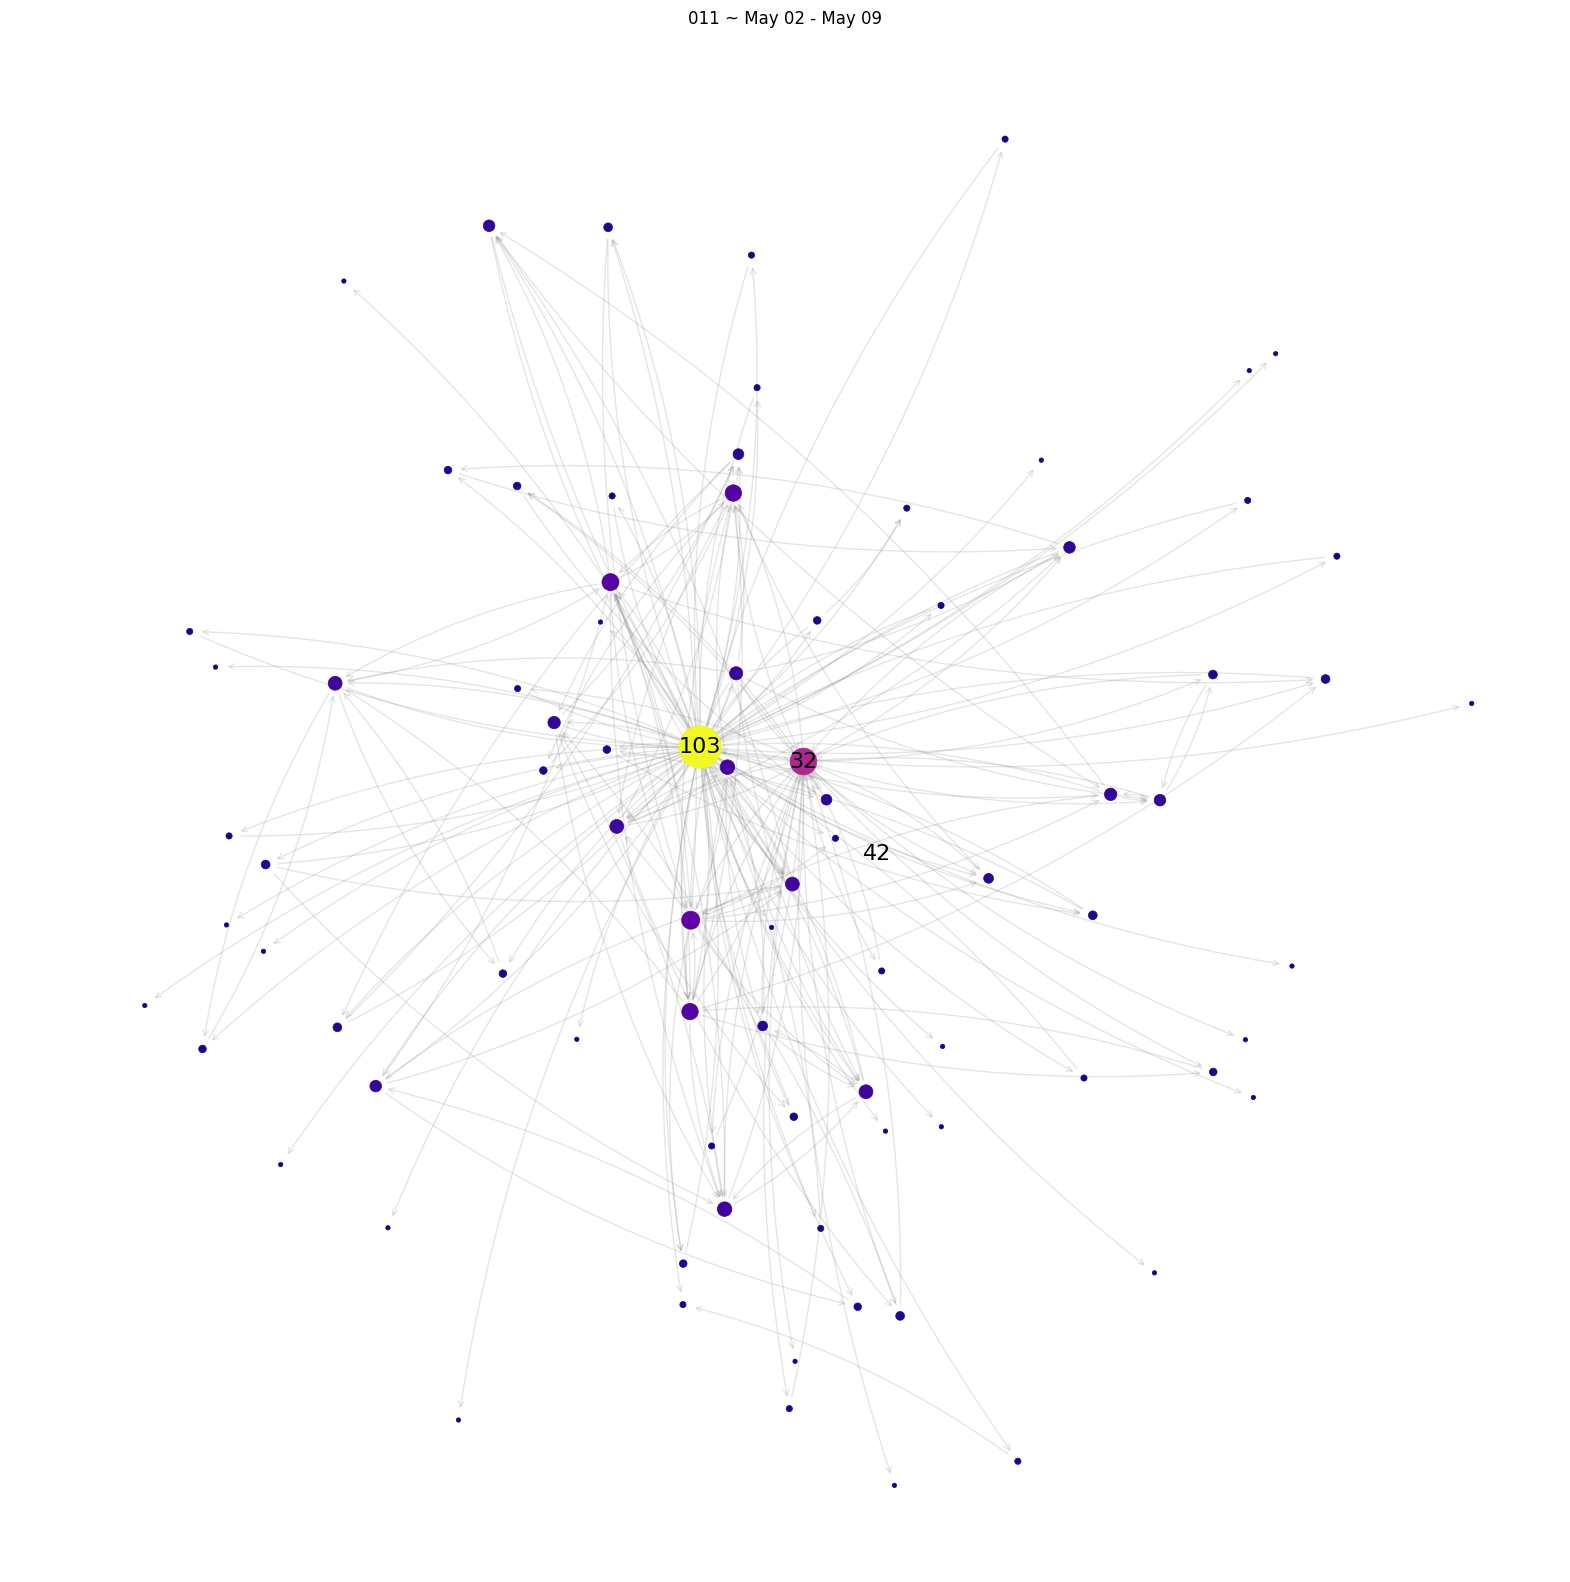

In [6]:
variations = (
    (7 * step, step) 
    for step in range(1, 8)
)

for variation in variations:
    export_time_windows_directed(cache_layout(GRAPH_MESSAGES, nx.arf_layout), top_3_betweenness_nodes, *variation)